## Automatyczne Uczenie Maszynowe
#### Laboratorium 4

*AutoGluon. Optymalizacja hipermarametór.*

### Zadanie 1
-----
Wykorzystując bazę zbiorów danych [OpenML](https://www.openml.org/) wybierz 3 zbiory (najlepiej z brakami danych):

a) zbiór do regresji

b) zbiór do klasyfikacji 

c) zbiór do multiklasyfikacji

Każdy zbiór danych podziel na część treningową i testową. Używając pakietu `AutoGluon` przygotuj modele i sprawdź ich jakość zarówno na zbiorze treningowym i testowym.

Odpowiedz na pytania:

1. Jakie są domyślne parametry i jakie wartości przyjmują?

2. Czy możemy określić czas działania pakietu? Jeżeli tak, to przetestuj 2-3 różne czasy i przedstaw wyniki modeli.

3. Jaki sposób optymalizacji hiperparametrów jest dostępny w `AutoGluon`?

4. Czy wyniki dla zespołów modeli (ensemblingi) są lepsze od poszczególnych modeli?

### Zadanie 2
----
Dla wybranego zbioru danych z Zadanie 1 przygotuj 2-3 modele na których zastosuj optymalizację hiperparametrów używając metody *random search*.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Porównaj uzyskane wyniki z wynikami Zadania 1. Które podejście otrzymuje lepsze wyniki? AutoGluon czy RandomSearch?

### Zadanie 3
----
Wykorzystując pakiet `scikit-optimize` przygotuj optymalizację hiperparametrów metodą bayesowską. 

https://scikit-optimize.github.io/stable/

https://colab.research.google.com/github/krasserm/bayesian-machine-learning/blob/master/bayesian_optimization.ipynb#scrollTo=sJMlow8JPDoi

Porównaj uzyskane wyniki z wynikami Zadania 1 oraz Zadania 2.

In [ ]:
# !pip install scikit-optimize
# !pip install GPy==1.9.8
# !pip install GPyOpt==1.2.1
# !pip install xgboost==0.90
# Get additional files from Github
#!wget https://raw.githubusercontent.com/krasserm/bayesian-machine-learning/master/bayesian_optimization_util.py

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

/tmp/ipykernel_14800/1936608359.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)


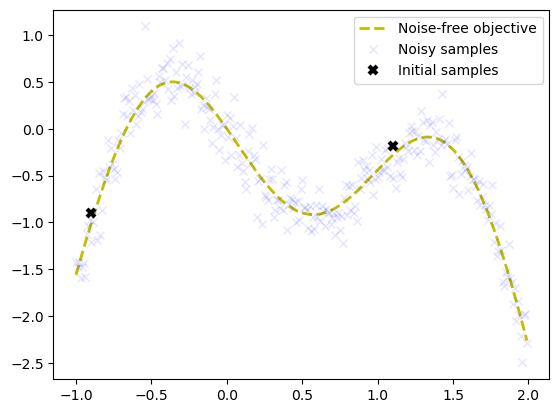

In [2]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

#### Scikit-optimize

https://scikit-opt.github.io/scikit-opt/#/en/README


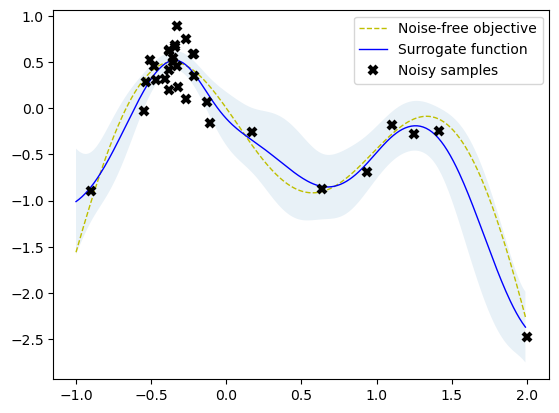

In [5]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition, plot_convergence

# Use custom kernel and estimator to match previous example
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

r = gp_minimize(lambda x: -f(np.array(x))[0], 
                bounds.tolist(),
                base_estimator=gpr,
                acq_func='EI',      # expected improvement
                xi=0.01,            # exploitation-exploration trade-off
                n_calls=30,         # number of iterations
                n_random_starts=0,  # initial samples are provided
                x0=X_init.tolist(), # initial samples
                y0=-Y_init.ravel())

# Fit GP model to samples for plotting results
gpr.fit(r.x_iters, -r.func_vals)

# Plot the fitted model and the noisy samples
plot_approximation(gpr, X, Y, r.x_iters, -r.func_vals, show_legend=True)

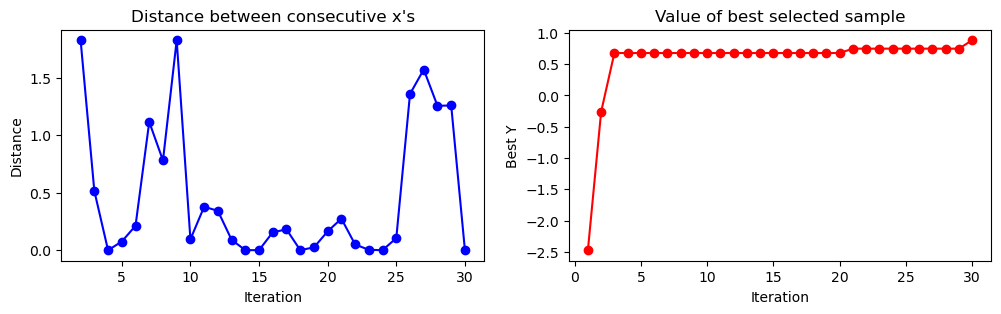

In [6]:
plot_convergence(np.array(r.x_iters), -r.func_vals)

#### SMAC-3

https://automl.github.io/SMAC3/main/examples/index.html

### Solution


In [8]:
import openml
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import numpy as np
import pandas as pd

# List all datasets and their properties
openml.datasets.list_datasets(output_format="dataframe")

# Get dataset by ID
dataset = openml.datasets.get_dataset(45068)
# Get the data itself as a dataframe (or otherwise)
X, y, _, _ = dataset.get_data(dataset_format="dataframe")


y = X['class']
X = X.drop('class', axis=1)

X_train,   X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)





In [9]:
# print(X_train.head())
print(y_train[:5])


24392     >50K
25669    <=50K
1205     <=50K
194      <=50K
8048     <=50K
Name: class, dtype: object


In [10]:
from sklearn.ensemble import RandomForestClassifier


### definition of model

# params_init = np.array([[-0.9], [1.1]])
# Y_init = f(X_init)

def rf_to_opt(params,X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())])

    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline, make_column_selector( dtype_include= np.number)),
    ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_))
    ],
    remainder='drop',
    n_jobs=-1)
    model_pipeline = Pipeline([('preprocessing', col_trans), 
                               ('model', RandomForestClassifier(n_estimators=np.int64(params[0])))])

    
    model_pipeline.fit(X_train, y_train)
    return model_pipeline.score(X_test, y_test)


# rf_to_opt(params=[50])


bounds = np.array([[5, 100]])
params_init = np.array([[np.int64(5)], [np.int64(20)]])
print(params_init)
acc_init = np.array([rf_to_opt(params=params_init[0]),rf_to_opt(params=params_init[1]) ])

    
        

[[ 5]
 [20]]


In [6]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition, plot_convergence

np.int = np.int_


noise = 0.2
# Use custom kernel and estimator to match previous example

m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

r = gp_minimize(lambda x: -rf_to_opt(params=x), 
                bounds.tolist(),
                base_estimator=gpr,
                acq_func='EI',      # expected improvement
                xi=0.01,            # exploitation-exploration trade-off
                n_calls=10,         # number of iterations
                n_random_starts=0,  # initial samples are provided
                x0=params_init.tolist(), # initial samples
                y0=-acc_init.ravel()
                )

# print(r)

## Fit GP model to samples for plotting results
gpr.fit(r.x_iters, -r.func_vals)

In [ ]:
plot_convergence(np.array(r.x_iters), -r.func_vals)